# Übung 3 | Gravitation (bepohl@ethz.ch)

![Test](./potential_acceleration.png)

## Interpretation

Das Potential setzt sich immer aus zwei Komponenten zusammen: V_innen + V_aussen. Auch wenn die Benennung etwas kontraintuitiv ist (die Komponenten heissen heissen V_innen für den "äusseren" Radius und vice versa V_aussen für den Bereich im "inneren" Radius) liegt das an der Perspektive. Am intuitivsten finde ich, wenn man sich überlegt was vom Abstand *d* abhängt und dann das jeweilige Integral nimmt. 

Die maximale Gravitationsbeschleunigung (10.69 m/s^2) befindet sich am äusseren Rand der zweiten Schicht (von innen) bei R = 3480 km (äusserer Kern). Erst einmal ist das gegen die Intuition, da man annehmen würde, dass mehr Masse zu höherer Beschleunigung führt. Da die Beschleunigung aber mit dem quadrierten Abstand abnimmt, kann durch eine (oder mehrere) **weniger dichte** Schichte(n) die Beschleunigung abnehmen. 

Im Plot oben gibt es noch ein lokales Maximum im Bereich des unteren Mantels. Diese Schicht hat auch eine höhere Dichte als die davor und erhöht die Beschleunigung minimal, nach dem wir genügend Abstand vom dichten Erdkern "gewonnen" haben. 

Unten ist der Code für die Erstellung des obigen Plots.

## Vorbereitung der Integrale

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
from tqdm import tqdm # for progress bars
import matplotlib.patches as mpatches

In [2]:
G = 0.0000000000667428 # in Nm^2 * kg^-2
R_e = 6371 * 10**3 # in m

prel_earth_ref_mod = pandas.read_csv("Data/preliminary_earth_reference_model.csv")
prel_earth_ref_mod *= 10**3 # all values in m or kg/m^3

In [3]:
def potential_integration_inner(R, B, C, D, E):
    return B * R**2 / 2 + C * R**3 / (3 * R_e) + D * R**4 / (4 * R_e**2) + E * R**5 / (5 * R_e**3)

def potential_integration_outer(R, B, C, D, E):
    return B * R**3 / 3 + C * R**4 / (4 * R_e) + D * R**5 / (5 * R_e**2) + E * R**6 / (6 * R_e**3)

In [4]:
def g_potential_inner(R_lower, R_upper, B, C, D, E):
    lower = potential_integration_inner(R_lower, B, C, D, E)
    upper = potential_integration_inner(R_upper, B, C, D, E)

    return 4 * np.pi * G * (upper - lower)

def g_potential_outer(R_lower, R_upper, d, B, C, D, E):
    lower = potential_integration_outer(R_lower, B, C, D, E)
    upper = potential_integration_outer(R_upper, B, C, D, E)

    return 4 * np.pi * G * (upper - lower) / d

### Test in Mittelpunkt der Erde

In [5]:
potential_per_shell = []
for index in prel_earth_ref_mod.index:
    R_lower = prel_earth_ref_mod.rmin[index]
    R_upper = prel_earth_ref_mod.rmax[index]

    B = prel_earth_ref_mod.B[index] 
    C = prel_earth_ref_mod.C[index]
    D = prel_earth_ref_mod.D[index]
    E = prel_earth_ref_mod.E[index]
    
    potential_per_shell.append(g_potential_inner(R_lower, R_upper, B, C, D, E))

prel_earth_ref_mod["potential_per_shell_in_middle"] = potential_per_shell
del potential_per_shell

## Plot des Gravitationspotentials

In [6]:
d = range(0, 4000000 * 10^3, 1000)
potential = []

for distance in tqdm(d):
    pot_per_distance = 0

    for index in prel_earth_ref_mod.index:
        R_lower = prel_earth_ref_mod.rmin[index]
        R_upper = prel_earth_ref_mod.rmax[index]

        B = prel_earth_ref_mod.B[index]
        C = prel_earth_ref_mod.C[index]
        D = prel_earth_ref_mod.D[index]
        E = prel_earth_ref_mod.E[index]

        if distance > R_upper:
            pot_per_distance += g_potential_outer(R_lower, R_upper, distance, B, C, D, E,)
        elif distance <= R_lower:
            pot_per_distance += g_potential_inner(R_lower, R_upper, B, C, D, E)
        else: pot_per_distance += g_potential_inner(distance, R_upper, B, C, D, E) + g_potential_outer(R_lower, distance, distance, B, C, D, E,)
    
    potential.append(pot_per_distance)

100%|██████████| 40001/40001 [00:17<00:00, 2288.81it/s]


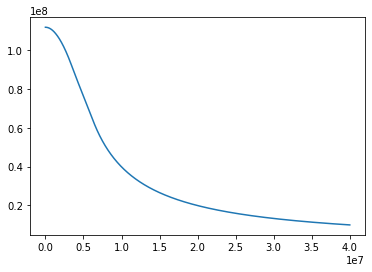

In [7]:
plt.plot(d, potential)

## Plot der Gravitationsbeschleunigung

In [8]:
d = range(0, 4000000 * 10^3, 1000)
acc = []

for distance in tqdm(d):
    pot_per_distance = 0

    for index in prel_earth_ref_mod.index:
        R_lower = prel_earth_ref_mod.rmin[index]
        R_upper = prel_earth_ref_mod.rmax[index]

        B = prel_earth_ref_mod.B[index]
        C = prel_earth_ref_mod.C[index]
        D = prel_earth_ref_mod.D[index]
        E = prel_earth_ref_mod.E[index]

        if distance > R_upper:
            pot_per_distance += g_potential_outer(R_lower, R_upper, distance**2, B, C, D, E,)
        elif distance <= R_lower:
            pot_per_distance += 0
        else: pot_per_distance += g_potential_outer(R_lower, distance, distance**2, B, C, D, E,)
    
    acc.append(pot_per_distance)

100%|██████████| 40001/40001 [00:17<00:00, 2339.84it/s]


Text(0.3, 0.6, 'Maximale Beschleunigung: -10.69 ms^(-2) \nbei 3480 km. \n\nBei R = 6371 km ist die \nBeschleunigung ca. -9.82 ms^(-2)')

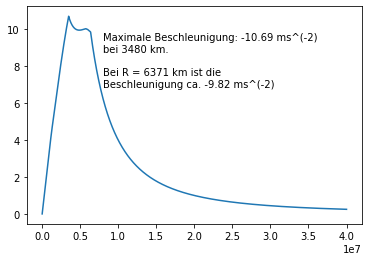

In [96]:
plt.plot(d, acc)
plt.figtext(0.3,0.6, "Maximale Beschleunigung: -" + str(round(max(acc),2)) + " ms^(-2) \nbei " + str(acc.index(max(acc))) + " km. \n\nBei R = 6371 km ist die \nBeschleunigung ca. -" + str(round(acc[6371],2)) + " ms^(-2)")

## Plot von PREM, Potential und Beschleunigung

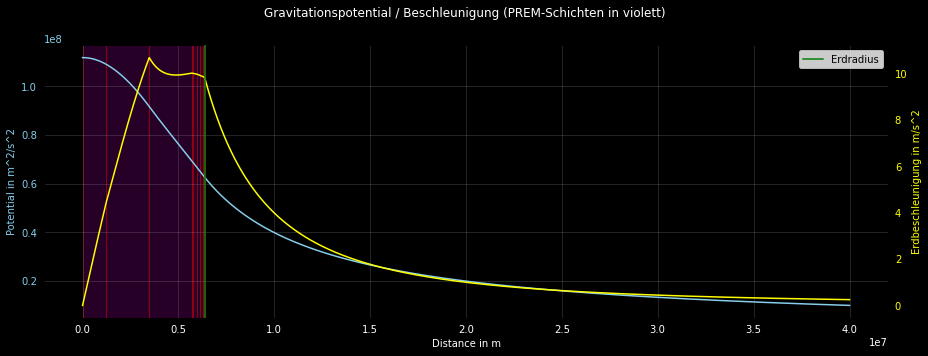

In [111]:
fig, ax1 = plt.subplots(figsize=(13,5))
fig.suptitle("Gravitationspotential / Beschleunigung (PREM-Schichten in violett)", color="white")

for shell in prel_earth_ref_mod.index:
    span = plt.axvspan(prel_earth_ref_mod.rmin[shell], prel_earth_ref_mod.rmax[shell], facecolor="purple", edgecolor="red", alpha=0.3, zorder=1)
    span.set_zorder(1)

color = 'skyblue'
ax1.set_xlabel('Distance in m', color="white")
ax1.set_ylabel('Potential in m^2/s^2', color=color)
ax1.plot(d, potential, color=color, label='Gravitationspotential', zorder=3)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', labelcolor="white")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'yellow'
ax2.set_ylabel('Erdbeschleunigung in m/s^2', color=color)
ax2.plot(d, acc, color=color, zorder=2.5)
ax2.tick_params(axis='y', labelcolor=color)

plt.axvline(x=R_e, ymin=0, ymax=1, color="green", label='Erdradius',zorder=3)

ax2.legend(loc=0)


ax1.set_facecolor('black')
fig.set_facecolor("black")
ax1.grid(alpha=0.25)

fig.tight_layout()

plt.savefig("potential_accelleration.png", dpi=400)